# Koan 6 — Collaborative filtering

The purpose of this notebook is to train a collaborative filtering
model that learns embedding vectors for both users and items,
supporting lookups of per-user or per-item recommendations.

This notebook uses the MovieLens 1m dataset, which has about 1 million
user/movie ratings. To get the data, download the file `ml-1m.zip` from
[here](https://grouplens.org/datasets/movielens/1m/). This notebook
loads the data from `ml-1m/ratings.dat`, which should exist once you
unzip that file.

## Imports

In [1]:
%matplotlib inline

# Non-torch imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

## Load the movie rating data

In [2]:
data = pd.read_csv(
    'ml-1m/ratings.dat',
    sep='::',
    engine='python',
    names=['userId', 'movieId', 'rating', 'timestamp']
)

In [3]:
# See a sample of the data.
data.sample(5)

,userId,movieId,rating,timestamp
876887,5299,2565,1,961005436
45626,307,2010,5,976485981
492915,3029,172,2,972845625
236248,1433,172,2,974760667
112604,731,2700,4,975529046


In [4]:
# How many ratings do we have?
len(data)

1000209

## Set up datasets and loaders

I'll do several interesting things here:
* Set up "internal ids" for movies and users. I'll do this to ensure that I have
  0-based, contiguous integer ids for all users and (separately) for all items (aka movies).
  I'll need this kind of an id so that they can serve as row indexes into embedding matrices.
* I'll dichotomize the labels as -1 or 1. The ratings given are in the range [1, 5], and I'll
  map 1 or 2 stars to -1 and 3 or more stars to 1. This is somewhat subjective, but this is
  how I see star ratings. You could argue that 3 stars should be closer to 0 but I think that if
  someone took the time to watch a movie and didn't actively dislike it, that tends to be
  a positive data point relative to the relationship between a random user and a random item,
  which mathematically we'd expect to be closer to 0.
* I'll save 10% of the data as test data. Since I've binarized the labels, we can use
  accuracy as an evaluation metric.

In [5]:
# Set up a custom dataset class.
class MovieDataset(Dataset):

    def __init__(self, data):

        # Make a public mapping between internal and external ids.
        # By "external" ids, I mean those in the original data.
        # And "internal" ids are 0-based and contiguous, indexing into the embedding matrices.
        self.to_ext_id = {i: m for i, m in enumerate(data['movieId'].unique())}
        self.to_int_id = {m: i for i, m in self.to_ext_id.items()}

        self.to_int_user_id = {u: i for i, u in enumerate(data['userId'].unique())}

        # Pull out these numbers to help initialize the model.
        self.num_users  = len(self.to_int_user_id)
        self.num_movies = len(self.to_int_id)

        # Store rating data with our internal ids.
        self.user_ids  = data['userId'].map(self.to_int_user_id).values
        self.movie_ids = data['movieId'].map(self.to_int_id).values
        self.ratings   = data['rating'].values
        self.ratings   = np.where(self.ratings <= 2, -1, 1)  # Binarize the labels.

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.user_ids[idx], self.movie_ids[idx], self.ratings[idx]

In [6]:
# Create the dataset and split into test and train subsets.
test_fraction = 0.1
dataset = MovieDataset(data)
train_ds, test_ds = random_split(dataset, [1 - test_fraction, test_fraction])

In [7]:
# Create the corresponding data loaders.
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)

## Define the model

This is a simple model. One way to think of it is that there is a single
user $u$ and a single movie $m$ as inputs. Consider both $u$ and $m$ to be
one-hot row vectors. The model has two matrices, $M$ for movies and $U$ for
users.

$M$ has size $\text{n\_movies}\times k$

$U$ has size $\text{n\_users}\times k$

The output of the model is:
$$m M U^T u^T,$$
which is a single scalar.

This is equivalent to taking the dot product $\langle M_m,U_u\rangle$.

In other words, the matrix product $MU^T$ is aiming to approximately match all
of the known rating values. The row $M_m$ is an embedding vector for movie $m$,
and the row $U_u$ is an embedding vector for user $u$; the dot product between
these is the predicted rating user $u$ would give for movie $m$. That's
a simple and typical collaborative filtering setup.

In [8]:
class CFModel(nn.Module):

    def __init__(self, num_users, num_movies, embedding_dim):
        super().__init__()
        self.user_matrix  = nn.Embedding(num_users,  embedding_dim)
        self.movie_matrix = nn.Embedding(num_movies, embedding_dim)

    def forward(self, user_ids, movie_ids):
        user_vecs  = self.user_matrix(user_ids)
        movie_vecs = self.movie_matrix(movie_ids)
        return (user_vecs * movie_vecs).sum(dim=1)

## Define the training process and test eval fn

In [9]:
def train(model, device, loader, loss_fn, opt, epochs, eval_fn, losses, evals):
    ''' Train `model` for `epochs` number of epochs.
        Both `losses` and `evals` are expected to be lists where we append
        one value (a loss or an eval metric) per epoch.
    '''
    for epoch in range(epochs):
        total_loss = 0
        model.train()
        for users, movies, ratings in tqdm(loader, ncols=50):
            
            users   = users.to(device)
            movies  = movies.to(device)
            ratings = ratings.float().to(device)

            opt.zero_grad()
            pred = model(users, movies)
            loss = loss_fn(pred, ratings)
            loss.backward()
            opt.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)

        metric = eval_fn(model)
        evals.append(metric)

        print(f'Epoch {epoch + 1:2d}/{epochs}. Train loss: {avg_loss:.4f}. Test loss: {metric:.4f}')

In [10]:
def get_eval_fn(model, loader, loss_fn):
    
    def eval_fn(model):
        model.eval()
        total_loss = 0
        for users, movies, ratings in loader:
            users   = users.to(device)
            movies  = movies.to(device)
            ratings = ratings.float().to(device)
            pred = model(users, movies)
            total_loss += loss_fn(pred, ratings).item()
        return total_loss / len(loader)

    return eval_fn

## Train the model

In [11]:
# Determine where training will happen.
device = 'cude' if torch.cuda.is_available() else 'cpu'

In [12]:
# Create the model.
# I'm using a small number for the embedding dimension to help avoid overfitting.
embedding_dim = 20
model = CFModel(dataset.num_users, dataset.num_movies, embedding_dim).to(device)

In [13]:
# Set up the loss function and optimizer.
# Setting the weight_decay value effectively gives us some regularization.
loss_fn = nn.MSELoss()
weight_decay = 2e-5
opt = optim.Adam(model.parameters(), lr=0.01, weight_decay=weight_decay)

In [14]:
# I'll track both the training and test loss values over time.
losses, evals = [], []

In [15]:
# I'll train in several sessions so that I can adjust the learning rate.
eval_fn = get_eval_fn(model, test_loader, loss_fn)
num_epochs = 6
train(model, device, train_loader, loss_fn, opt, num_epochs, eval_fn, losses, evals)

100%|█████| 14066/14066 [00:12<00:00, 1084.21it/s]


Epoch  1/6. Train loss: 1.1277. Test loss: 0.5367


100%|█████| 14066/14066 [00:12<00:00, 1147.88it/s]


Epoch  2/6. Train loss: 0.5178. Test loss: 0.5119


100%|█████| 14066/14066 [00:12<00:00, 1111.66it/s]


Epoch  3/6. Train loss: 0.5081. Test loss: 0.5081


100%|█████| 14066/14066 [00:12<00:00, 1147.85it/s]


Epoch  4/6. Train loss: 0.5076. Test loss: 0.5090


100%|█████| 14066/14066 [00:11<00:00, 1179.64it/s]


Epoch  5/6. Train loss: 0.5078. Test loss: 0.5079


100%|█████| 14066/14066 [00:12<00:00, 1148.77it/s]


Epoch  6/6. Train loss: 0.5068. Test loss: 0.5072


In [16]:
# Decrease the learning rate.
for param_group in opt.param_groups:
    param_group['lr'] = 0.001

In [17]:
# The second session of training.
train(model, device, train_loader, loss_fn, opt, num_epochs, eval_fn, losses, evals)

100%|█████| 14066/14066 [00:12<00:00, 1099.06it/s]


Epoch  1/6. Train loss: 0.4179. Test loss: 0.4134


100%|█████| 14066/14066 [00:13<00:00, 1075.03it/s]


Epoch  2/6. Train loss: 0.3860. Test loss: 0.4037


100%|█████| 14066/14066 [00:13<00:00, 1079.88it/s]


Epoch  3/6. Train loss: 0.3766. Test loss: 0.4003


100%|██████| 14066/14066 [00:14<00:00, 973.18it/s]


Epoch  4/6. Train loss: 0.3695. Test loss: 0.3986


100%|█████| 14066/14066 [00:13<00:00, 1069.62it/s]


Epoch  5/6. Train loss: 0.3647. Test loss: 0.3982


100%|██████| 14066/14066 [00:14<00:00, 982.92it/s]


Epoch  6/6. Train loss: 0.3614. Test loss: 0.3977


In [18]:
# Decrease the learning rate.
for param_group in opt.param_groups:
    param_group['lr'] = 0.00001

In [19]:
train(model, device, train_loader, loss_fn, opt, num_epochs, eval_fn, losses, evals)

100%|█████| 14066/14066 [00:12<00:00, 1135.00it/s]


Epoch  1/6. Train loss: 0.3381. Test loss: 0.3975


100%|█████| 14066/14066 [00:12<00:00, 1161.83it/s]


Epoch  2/6. Train loss: 0.3378. Test loss: 0.3974


100%|█████| 14066/14066 [00:11<00:00, 1216.74it/s]


Epoch  3/6. Train loss: 0.3376. Test loss: 0.3973


100%|█████| 14066/14066 [00:12<00:00, 1165.49it/s]


Epoch  4/6. Train loss: 0.3373. Test loss: 0.3971


100%|█████| 14066/14066 [00:12<00:00, 1107.11it/s]


Epoch  5/6. Train loss: 0.3370. Test loss: 0.3970


100%|█████| 14066/14066 [00:12<00:00, 1092.52it/s]


Epoch  6/6. Train loss: 0.3368. Test loss: 0.3970


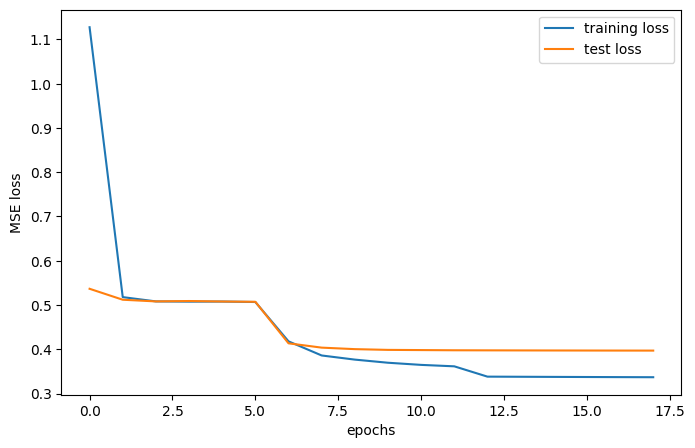

In [20]:
# Plot the training and test loss values over time.
plt.figure(figsize=(8, 5))
plt.plot(losses, label='training loss')
plt.plot(evals,  label='test loss')
plt.xlabel('epochs')
plt.ylabel('MSE loss')
plt.legend()
plt.show()

In [21]:
# Check some stats on the accuracy of the model.

model.eval()
total_inputs, num_correct = 0, 0
num_true_pos, num_pred_pos, num_corr_pos = 0, 0, 0

for users, movies, ratings in test_loader:
    
    users   = users.to(device)
    movies  = movies.to(device)
    ratings = np.array(ratings.float())
    pred = model(users, movies)
    pred = np.where(pred >= 0, 1, -1)

    num_true_pos += np.where(ratings == 1, 1, 0).sum()
    num_pred_pos += np.where(pred == 1, 1, 0).sum()
    num_corr_pos += np.where((ratings == 1) * (pred == 1), 1, 0).sum()

    total_inputs += users.size(0)
    num_correct  += int((pred == ratings).sum())

print(f'Perc true pos : {100 * num_true_pos / total_inputs:.2f}%')
acc = num_correct / total_inputs
print(f'Accuracy      : {100 * acc:.2f}%')
print(f'Precision     : {100 * num_corr_pos / num_pred_pos:.2f}%')
print(f'Recall        : {100 * num_corr_pos / num_true_pos:.2f}%')

Perc true pos : 83.59%
Accuracy      : 86.85%
Precision     : 88.24%
Recall        : 97.22%


### Note

The accuracy is only slightly higher than the baseline of predicting
all pairs as positive. However, we can get a stronger sense that the
model is actually learning something by looking at nearest neighbors
in the embedding space.

## Perform some neighbor lookups

The purpose of this section is to show how you can actually produce recommendations.
You could produce recommendations for a particular user, but those are hard to evaluate.
So in this section, I'll look up recommendations based on a movie query. This is working
well when you can say "based on liking the query movie, you'd probably also like these
other movies." The last cell in this section shows the results.

In [22]:
# Load in the titles of the movies by movieId, along with other data.
movie_data = pd.read_csv(
    'ml-1m/movies.dat',
    sep='::',
    engine='python',
    names=['movieId', 'title', 'genre'], encoding='cp1252'
)

In [23]:
# Make the movieId the default index.
movie_data = movie_data.set_index('movieId')

In [24]:
# Pull out the embedding matrix and normalize all the rows.
# Normalizing the rows makes it easier to perform lookups based on cosine similarity,
# which I think tends to give us better results.
movie_mat = model.movie_matrix.weight.data
row_norms = torch.norm(movie_mat, dim=1, keepdim=True)
row_norms[row_norms == 0] = 1.0
movie_mat = movie_mat / row_norms

In [25]:
# Find out how many ratings we have for each movie.
# Movies with few ratings are likely to have unreliable results, and to be
# more obscure, so we can decide to filter those out.
counts = data['movieId'].value_counts()

In [26]:
# I'll define a function to print out movies close to a source movie.
def print_recs_for_movieid(movieid):

    k = 300  # We'll look up 300 movies before they're filtered by popularity (ratings count).

    # Find the top k nearest neighbors by embedding vectors.
    movie_idx = dataset.to_int_id[movieid]
    movie_vec = movie_mat[movie_idx]
    scores = np.array(movie_mat @ movie_vec)
    top_k = np.array(np.argsort(scores))[::-1][:k]

    # We'll print out the top 10 results.
    num_printed = 0
    
    for model_idx in top_k:
        movieId = dataset.to_ext_id[model_idx]
    
        if counts[movieId] < 300:
            continue
    
        movie_row = movie_data.loc[movieId]
        print(
            f'{num_printed + 1:2d}.',
            f'id={movieId:4d} model_idx={model_idx:4d} score={scores[model_idx]:.3f}',
            f' {movie_row.title:30s}',
            movie_row.genre,
            f'count={counts[movieId]}'
        )
    
        num_printed += 1
        if num_printed == 10:
            break

In [27]:
sample_movies = [
    480,   # Jurassic Park
    1197,  # The Princess Bride
    733,   # The Rock
    783,   # The Hunchback of Notre Dame
    608,   # Fargo
    3362,  # Dog Day Afternoon
    223    # Clerks
]

In [28]:
for movieid in sample_movies:
    print('_' * 80)
    print_recs_for_movieid(movieid)

________________________________________________________________________________
 1. id= 480 model_idx= 113 score=1.000  Jurassic Park (1993)           Action|Adventure|Sci-Fi count=2672
 2. id=1036 model_idx= 210 score=0.896  Die Hard (1988)                Action|Thriller count=1666
 3. id=3510 model_idx= 519 score=0.892  Frequency (2000)               Drama|Thriller count=821
 4. id=2872 model_idx= 720 score=0.890  Excalibur (1981)               Action|Drama|Fantasy|Romance count=742
 5. id=2406 model_idx= 385 score=0.888  Romancing the Stone (1984)     Action|Adventure|Comedy|Romance count=1345
 6. id=2000 model_idx= 711 score=0.869  Lethal Weapon (1987)           Action|Comedy|Crime|Drama count=1627
 7. id=2268 model_idx=  59 score=0.868  Few Good Men, A (1992)         Crime|Drama count=1061
 8. id=2993 model_idx=1022 score=0.863  Thunderball (1965)             Action count=404
 9. id= 805 model_idx= 518 score=0.851  Time to Kill, A (1996)         Drama count=344
10. id=3505 model_